# Train VGGNet and FCN as Segmentation model
## Breast-Ultrasound-Segmentation

## About Dataset
Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

### Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

If you use this dataset, please cite:
Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}/data"

In [2]:
import torch
import torch.nn as nn

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [3]:
import hydra
from hydra import compose, initialize

In [4]:
# # auto reload dotenv
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths setup

In [5]:
from omegaconf import DictConfig, OmegaConf

# Register a resolver for torch dtypes
OmegaConf.register_new_resolver("torch_dtype", lambda name: getattr(torch, name))

with initialize(config_path="../configs", job_name="training_setup", version_base=None):
    cfg: DictConfig = compose(config_name="train.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.models)

{'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': 0.001, 'weight_decay': 0.0, 'betas': [0.9, 0.999]}, 'scheduler': {'func': None}, 'model': {'_target_': 'src.models.vggnet_fcn_segmentation_model.VGGNetFCN16SegmentationModel', 'num_classes': 3}}


In [6]:
os.chdir(root)

## Loading Dataset

In [7]:
data_module = hydra.utils.instantiate(cfg.datamodule)

class_weights = data_module.class_weights
class_names = data_module.classes
num_classes = len(class_names)
class_names, num_classes, class_weights

(['normal', 'malignant', 'benign'], 3, tensor([1.9774, 1.2494, 0.5903]))

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# # 1. Select a very small subset of your data
train_dataset, val_dataset = data_module.split_and_preprocess_datasets()

subset_indices = list(range(10))  # Select first 10 samples
train_small_dataset = Subset(train_dataset, subset_indices)
val_small_dataset = Subset(val_dataset, subset_indices)
train_dl = DataLoader(train_small_dataset, batch_size=5, shuffle=False)
val_dl = DataLoader(val_small_dataset, batch_size=5, shuffle=False)

In [9]:
for images, targets in train_dl:
    print(images.shape, targets["masks"].shape, targets["labels"].shape)

    print(f"images:{images.dtype}, {images[0].min()}, {images[0].max()}")
    print(
        f'masks {targets["masks"].dtype}, {targets["masks"][0].min()}, {targets["masks"][0].max()}'
    )
    print(
        f'labels {targets["labels"].dtype}, {targets["labels"].min()}, {targets["labels"].max()}'
    )
    break

torch.Size([5, 3, 224, 224]) torch.Size([5, 1, 224, 224]) torch.Size([5])
images:torch.float32, -2.1179039478302, 2.640000104904175
masks torch.uint8, 0, 1
labels torch.int64, 1, 2


In [10]:
for _images, _targets in val_dl:
    print(_images.shape, _targets["masks"].shape, _targets["labels"].shape)

    print(f"images:{_images[0].dtype}, {_images[0].min()}, {_images[0].max()}")
    print(f'masks {_targets["masks"].dtype}, {_targets["masks"].min()}, {_targets["masks"].max()}')
    print(
        f'labels {_targets["labels"].dtype}, {_targets["labels"].min()}, {_targets["labels"].max()}'
    )
    break

torch.Size([5, 3, 224, 224]) torch.Size([5, 1, 224, 224]) torch.Size([5])
images:torch.float32, -2.1179039478302, 2.5354254245758057
masks torch.uint8, 0, 1
labels torch.int64, 0, 2


## Loading and training the FCN8 model 

In [11]:
from src.utils.gpu_utils import DeviceDataLoader, get_default_device, to_device

torch.cuda.empty_cache()
device = get_default_device()

gpu_weights = to_device(class_weights, device)

In [12]:
from src.models.vggnet_fcn8_segmentation_model import VGGNetFCN8SegmentationModel

model = VGGNetFCN8SegmentationModel(
    num_classes=num_classes,
    vggnet_type="vgg16",
    # class_weights=gpu_weights,
    segmentation_criterion=nn.CrossEntropyLoss(),
    classification_criterion=nn.CrossEntropyLoss(weight=gpu_weights),
)
model = torch.compile(model)
model

OptimizedModule(
  (_orig_mod): VGGNetFCN8SegmentationModel(
    (segmentation_criterion): CrossEntropyLoss()
    (classification_criterion): CrossEntropyLoss()
    (encoder): VGGNetEncoder(
      (vgg): VGG(
        (features): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (6): ReLU(inplace=True)
          (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (8): ReLU(inplace=True)
          (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (11): ReLU(inplace=True

In [13]:
for images, labels in train_dl:
    # print(images.shape, labels)
    out = model(images)
    # l = labels['labels'][0]
    # print(l , torch.argmax(l))
    print(out["labels"][0], out["labels"].shape)
    print(out["masks"][0])
    print(out["masks"].shape)
    break

tensor([-0.0280, -0.0601, -0.0400], grad_fn=<SelectBackward0>) torch.Size([5, 3])
tensor([[[ 0.2217,  0.4533, -0.2362,  ..., -0.0991,  0.1820, -0.3981],
         [-0.4762,  0.0610, -0.2882,  ..., -0.3821, -0.1835,  0.1531],
         [ 0.2427, -0.0021, -0.8194,  ..., -0.0435,  0.0468, -0.5177],
         ...,
         [-1.1953,  0.7841, -1.6076,  ...,  0.2585, -0.5988, -0.6560],
         [ 0.1092,  0.3181,  0.4308,  ...,  0.1388,  0.6095,  0.9809],
         [ 0.0249, -1.6544,  0.0896,  ..., -1.7758, -1.1326,  0.4621]],

        [[-0.0490,  0.0566,  0.0811,  ...,  0.3426, -0.0279,  0.1367],
         [ 0.0827,  0.4742,  1.1841,  ...,  0.1159, -0.2437,  0.2171],
         [-0.1569,  0.6254,  0.3810,  ..., -0.2084, -0.1497, -0.0424],
         ...,
         [ 0.3016,  0.5003,  0.7117,  ...,  0.6720, -0.8637, -0.6873],
         [ 0.2908, -0.2330,  0.6262,  ..., -1.0957, -0.2563,  0.2996],
         [-0.3628,  0.0792,  0.7188,  ...,  0.8495,  0.2817,  0.5719]],

        [[ 0.4832,  0.2969,  0.016

### Evaluate function

In [14]:
@torch.no_grad()
def evaluate(model, val_dl) -> dict[str, float]:
    model.eval()  # set model to evaluate mode
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

In [15]:
def fit(
    model,
    train_dataloader,
    validation_dataloader,
    epochs: int = 2,
    lr: float = 1e-3,
    opt_func=torch.optim.Adam,
) -> list[dict[str, float]]:
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accuracies = []

        train_losses = []
        for batch in train_dataloader:
            step_output = model.training_step(batch)
            loss = step_output["loss"]
            train_acc = step_output["train_acc"]
            # Detach loss and accuracy before appending to avoid holding onto computation graph
            train_losses.append(loss.detach())
            train_accuracies.append(train_acc.detach())  # Assuming train_acc is a tensor

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation Phase
        result = evaluate(model, validation_dataloader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        result["train_acc"] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [16]:
# evaluate(model, val_dl)

## GPU Training Setup

### Utils preparation

## Moving data and model into memory

### Train only Classification head 

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)
# train_dl.device

OptimizedModule(
  (_orig_mod): VGGNetFCN8SegmentationModel(
    (segmentation_criterion): CrossEntropyLoss()
    (classification_criterion): CrossEntropyLoss()
    (encoder): VGGNetEncoder(
      (vgg): VGG(
        (features): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (6): ReLU(inplace=True)
          (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (8): ReLU(inplace=True)
          (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (11): ReLU(inplace=True

In [18]:
num_epochs = 20  # Train for significantly more epochs than usual

# history = fit(
#     model=model,
#     train_dataloader=train_dl,
#     validation_dataloader=val_dl,
#     epochs=num_epochs,
#     lr=1e-4,
#     opt_func=optim.Adam,
# )

In [19]:
from src.utils.visualizations import plot_losses

# plot_losses(history)

## Image Segmentation

In [27]:
import enum


class MetricKey(enum.Enum):
    """Keys for metrics dictionary."""

    # Classification
    CLS_LOSS = "cls_loss"
    CLS_ACC = "cls_acc"
    VAL_CLS_LOSS = "val_cls_loss"
    VAL_CLS_ACC = "val_cls_acc"

    # Segmentation
    SEG_LOSS = "seg_loss"
    SEG_DICE = "seg_dice"
    VAL_SEG_LOSS = "val_seg_loss"
    VAL_SEG_DICE = "val_seg_dice"


def fit_seg(
    model,
    train_dataloader,
    validation_dataloader,
    epochs: int = 2,
    lr: float = 1e-3,
    opt_func=torch.optim.Adam,
) -> list[dict[str, float]]:
    history = []
    result = {}
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        masks_dice_sc = []
        train_accuracies = []
        loss = []
        masks_losses = []
        for batch in train_dataloader:
            step_output = model.training_step(batch)
            masks_loss = step_output[f"{MetricKey.SEG_LOSS.value}"]
            _masks_dice_sc = step_output[f"{MetricKey.SEG_DICE.value}"]

            train_acc = step_output[f"{MetricKey.CLS_ACC.value}"]
            loss = step_output[f"{MetricKey.CLS_LOSS.value}"]
            # Detach loss and accuracy before appending to avoid holding onto computation graph
            train_losses.append(loss.detach())
            masks_losses.append(masks_loss.detach())  # Assuming train_acc is a tensor
            masks_dice_sc.append(_masks_dice_sc)  # Assuming train_acc is a tensor
            train_accuracies.append(train_acc.detach())  # Assuming train_acc is a tensor

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation Phase
        result = evaluate(model, validation_dataloader)
        result[f"{MetricKey.CLS_LOSS.value}"] = torch.stack(train_losses).mean().item()
        result[f"{MetricKey.SEG_LOSS.value}"] = torch.stack(masks_losses).mean().item()
        result[f"{MetricKey.SEG_DICE.value}"] = torch.stack(masks_dice_sc).mean().item()
        result[f"{MetricKey.CLS_ACC.value}"] = torch.stack(train_accuracies).mean().item()
        model.epoch_end(epoch, result)
        # history.append(result)
    return history

In [28]:
# TODO: try using dice loss
history = fit_seg(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    epochs=num_epochs + 50,
    lr=1e-5,
    opt_func=optim.Adam,
)

Epoch [0] Validation Results: val_cls_loss=1.0882, val_cls_acc=0.6000, val_seg_loss=1.1820, val_seg_dice=0.1332
Epoch [1] Validation Results: val_cls_loss=1.0850, val_cls_acc=0.6000, val_seg_loss=1.1868, val_seg_dice=0.1338
Epoch [2] Validation Results: val_cls_loss=1.0815, val_cls_acc=0.6000, val_seg_loss=1.1911, val_seg_dice=0.1340
Epoch [3] Validation Results: val_cls_loss=1.0773, val_cls_acc=0.6000, val_seg_loss=1.1948, val_seg_dice=0.1338
Epoch [4] Validation Results: val_cls_loss=1.0729, val_cls_acc=0.6000, val_seg_loss=1.1980, val_seg_dice=0.1335
Epoch [5] Validation Results: val_cls_loss=1.0682, val_cls_acc=0.6000, val_seg_loss=1.2007, val_seg_dice=0.1331
Epoch [6] Validation Results: val_cls_loss=1.0633, val_cls_acc=0.6000, val_seg_loss=1.2029, val_seg_dice=0.1327
Epoch [7] Validation Results: val_cls_loss=1.0580, val_cls_acc=0.6000, val_seg_loss=1.2048, val_seg_dice=0.1323
Epoch [8] Validation Results: val_cls_loss=1.0520, val_cls_acc=0.6000, val_seg_loss=1.2063, val_seg_dice

Text(0.5, 1.0, 'Loss vs. NO. of epochs')

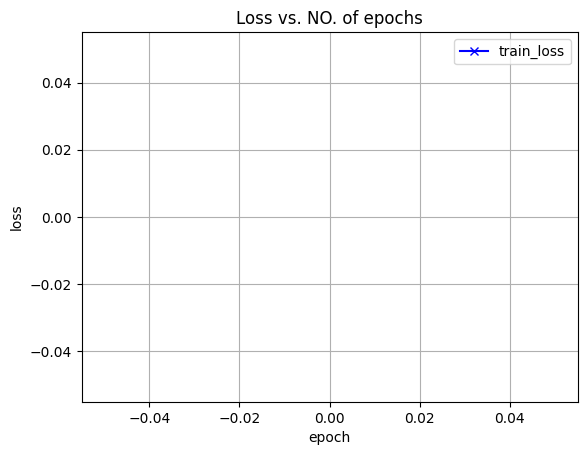

In [29]:
import matplotlib.pyplot as plt

train_losses = [x["train_loss"] for x in history]

plt.plot(train_losses, "-bx")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend(["train_loss"])
plt.title("Loss vs. NO. of epochs")

In [30]:
import torch
import torch.nn.functional as F

# Example predictions (logits) and targets
predictions = torch.randn(32, 3, 224, 224)
targets = torch.randint(0, 3, (32, 224, 224), dtype=torch.long)

targets.shape, predictions.shape

(torch.Size([32, 224, 224]), torch.Size([32, 3, 224, 224]))

In [31]:
# Calculate the loss using the functional form
loss = F.cross_entropy(predictions, targets)
print(loss.item())

# You can also specify arguments directly in the function call
loss_with_reduction = F.cross_entropy(predictions, targets, reduction="sum")
print(loss_with_reduction.item())

1.3901805877685547
2232118.5
